In [3]:

from acados_template import AcadosOcp, AcadosOcpSolver, AcadosModel
from casadi import SX, vertcat, tan, cos, sin, mtimes
import numpy as np
from systems import *
from controllers import *

class TrajectoryTimeProfile:
    def __init__(self, f_vel, f_curv):
        self.vel_profile = f_vel
        self.curv_profile = f_curv

def adaptation(what, params, un, table):
    f1 = un*0
    f2 = 0.1


    theta = np.array([f1, f2])
    vec_size = len(theta)
    ua = what[:vec_size]@theta
    ids = np.arange(0, vec_size)
    ids_features = np.arange(0, vec_size)
    return ua, ids, ids_features,  theta

class Mrac:
    def __init__(self, 
                 referene_model: AcadosModel, 
                 controller: Controller,
                 adaptation_f,
                 gamma, sigma):
        self.referene_model = referene_model
        self.controller = controller
        self.integrator = Integrator(referene_model)
        self.gamma = gamma
        self.adaptation_f = adaptation_f
        self.R = np.once(len(referene_model.x.elements))
        #Simulation parameters
        ADAPT_VECTOR_SIZE = 5
        self.what = np.zeros(ADAPT_VECTOR_SIZE)
        self.whatf = np.zeros(ADAPT_VECTOR_SIZE)
        self.alfa_sm = 0.0
        self.gam = gamma
        self.sig = sigma
    def reset(self, x0):
        self.ref_state = x0
   
    def step(self, state, un, params, dt):
        d = self.ref_state[0]
        v, c = params[:2]
        self.controller.set_params(params)
        print("ref state", self.ref_state)
        u_ref = self.controller.action(np.hstack((d/v, self.ref_state[1:])))
        self.ref_state = self.integrator.step(self.ref_state, u_ref, params, dt)
        A, B = self.integrator.get_lin_system_dynamics(self.ref_state, u_ref, params)
        K_fb = self.controller.get_fb_gain()
        A_close = get_close_loop_matrix(A, B, K_fb)
        eigs_close_loop_real = np.real(eig(A_close)[0])

        P = linalg.solve_continuous_lyapunov(A_close.T, np.diag(self.R))
        BTP = -P@B
        err = state - self.ref_state
        err_mrac = err@BTP
        print("err_mrac: ", err_mrac)
        ua, ids, ids_f, thetas = self.adaptation_f(self.what, params, un, False)
        assert len(ids) == len(thetas)
        for j, id in enumerate(ids):   
            f_id = ids_f[j]
            self.what[id] += (self.gam[f_id] * (thetas[j] * err_mrac)- self.sig[id] * (self.what[id] - self.whatf[id])) * dt
            self.whatf[id] += (self.alfa_sm * (self.what[id] - self.whatf[id])) * dt
        # print(eigs_close_loop_real)
        # if(not np.all(eigs_close_loop_real < 0.0)):
        #     raise BaseException("positive eigenvals")
        
        return self.ref_state, ua

ref_model = make_acados_model(KinematicBycicleActuator(), "kinemetic")
controller = PID_Controller(K_fb=np.array([0.02, 0.1, 0, 0]), wheelbase = 1.0*2.5)

integrator = Integrator(ref_model)
ref_state = np.array([0.1, 0.03, 0, 0])
params = np.array([10, 0.1])
controller.set_params(params)
u_ref = np.array([0])#controller.action(ref_state)*0
A, B = integrator.get_lin_system_dynamics(ref_state, u_ref, params)

K_fb = controller.get_fb_gain()
A_close = get_close_loop_matrix(A, B, K_fb)


R = np.array([1,2, 1, 1])
P = linalg.solve_continuous_lyapunov(A_close.T, np.diag(R))


eigs_close_loop_real = np.real(eig(A_close)[0])
BTP = -P@B
err_mrac = ref_state@BTP
# mrac = Mrac(ref_model, controller, 0.01, 0)
# mrac.reset(np.array([0.1, 0.01]))
# mrac.step(np.array([10, 0.01, 2.65]))
#         BTP = -B@P

In [4]:
A, A_close, eigs_close_loop_real, P, K_fb,  BTP, err_mrac

(array([[ 0.00000000e+00,  9.99550034e+00,  0.00000000e+00,
          0.00000000e+00],
        [-1.01984495e-01,  3.02984851e-02,  4.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00, -4.20900000e+02,
         -4.06100000e+01]]),
 array([[ 0.00000000e+00,  9.99550034e+00,  0.00000000e+00,
          0.00000000e+00],
        [-1.01984495e-01,  3.02984851e-02,  4.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00],
        [-8.41800000e+00, -4.20900000e+01, -4.20900000e+02,
         -4.06100000e+01]]),
 array([-20.1408948 , -20.1408948 ,  -0.14895595,  -0.14895595]),
 array([[-1.85502070e+00, -3.51854725e+00, -9.55641324e-01,
         -1.67691537e-02],
        [-3.51854725e+00, -9.91143045e+01, -3.84980722e+01,
         -9.30687896e-01],
        [-9.55641324e-01, -3.84980722e+01, -2.01697529e+01,


In [25]:
import numpy as np

from scipy import interpolate


def simulate_car_control(real_model:AcadosModel, 
                         controller: Controller, 
                         trajectory: TrajectoryTimeProfile,
                         dt, t_list):

    integrator = Integrator(real_model)
    mrac = Mrac(real_model, controller, adaptation, gamma = 10*np.array([0.1, 0.1, 0.1]), sigma = 0*np.array([0.1, 0.1, 0.1]))

    # Initial state
    STATE_LENGTH = len(real_model.x.elements())
    x0 = np.zeros(STATE_LENGTH)
    x0[0] = 0.1
    x0[1] = 0.02
    mrac.reset(x0)
    # Storage
    N_sim = len(t_list)
    states = np.zeros((N_sim + 1, 10))
    controls = np.zeros((N_sim, 1))
    controls_actual = np.zeros((N_sim, 1))
    debug_w =  np.zeros((N_sim, 5))
    states[0, :STATE_LENGTH] = x0
    x_current = x0
    x0_solver = np.zeros(4)
    x0_solver[0] = x_current[0]/trajectory.vel_profile(t_list[0])
    x0_solver[1] = x_current[1]

    control_gain = 1.0 #* 0.9 
    control_bias = 0.0005
    use_distortion = 1
    
    def disturbance(u):
        # return u
        return (u + control_bias) * control_gain
    
    for i, t in enumerate(t_list[:-1]):
        curr_curv = trajectory.curv_profile(t)
        curr_vel = trajectory.vel_profile(t)
        params = np.hstack((curr_vel, curr_curv))
        controller.set_params(params)
        u_n = controller.action(x0_solver)[0]
        u = disturbance(u_n)
        
        ref_model_state, ua = mrac.step(x_current, u_n, params, dt)
        print("U", u, ua)
        
        x_current = integrator.step_jax(x_current, np.array([u - ua]), params, dt)
        print("t", t, x_current)
        
        d, psi = x_current[:2]
        x0_solver = np.hstack((d/curr_vel, x_current[1:]))  

        controls[i] = controller.get_data()
        controls_actual[i] = u
        states[i+1, :STATE_LENGTH] =  x_current
        states[i+1, STATE_LENGTH: STATE_LENGTH*2] =  ref_model_state
        debug_w[i] = mrac.what
    return t_list, states, controls, controls_actual, debug_w


def plot_results(times, states, controls, controls_actual, debug):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))
    
    ax1.plot(times, states[:-1, 0], 'b-', linewidth=2)
    ax1.plot(times, states[:-1, 2], 'r-', linewidth=2)
    ax1.set_ylabel('Lateral deviation [m]')
    ax1.grid(True)
    ax1.axhline(y=0, color='r', linestyle='--')
    
    ax2.plot(times, states[:-1, 1], 'g-', linewidth=2)
    ax2.plot(times, states[:-1, 3], 'r-', linewidth=2)
    ax2.set_ylabel('Heading angle [rad]')
    ax2.grid(True)
    ax2.axhline(y=0, color='r', linestyle='--')
    
    #ax3.plot(times, states[:-1, 2], 'g-', linewidth=2)
    ax3.plot(times, controls_actual, 'k', linewidth=2)
    ax3.set_ylabel('Steering angle[rad]')
    ax3.grid(True)
    ax3.axhline(y=0, color='r', linestyle='--')

    ax4.plot(times[:], debug[:, :], linewidth=2)
    ax4.grid(True)
    # ax4.set_ylabel('qq]')
    # ax4.set_xlabel('Time [s]')
    # ax4.grid(True)
    # ax4.axhline(y=0, color='k', linestyle='--')
    
    plt.tight_layout()
    plt.show()



In [ ]:
real_model = make_acados_model(KinematicBycicle(), "kinematic")
real_model.x.elements()


SX([d, psi])

action
[0.2 0.2 0.  0. ] [0.00588235 0.02       0.         0.        ]
ref state [0.1  0.02 0.   0.  ]
action
[0.2 0.2 0.  0. ] [0.00588235 0.02       0.         0.        ]
err_mrac:  [0.06052405]
U -0.004676470588235294 0.0


/tmp/ipykernel_1740616/2005617627.py:67: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.what[id] += (self.gam[f_id] * (thetas[j] * err_mrac)- self.sig[id] * (self.what[id] - self.whatf[id])) * dt


t 0.0 [ 1.0339975e-01  1.9997971e-02 -8.6049724e-05 -1.6063921e-02]
action
[0.2 0.2 0.  0. ] [ 6.08233845e-03  1.99979711e-02 -8.60497239e-05 -1.60639212e-02]
ref state [ 1.03399677e-01  1.99977669e-02 -9.52500776e-05 -1.77814373e-02]
action
[0.2 0.2 0.  0. ] [ 6.08233391e-03  1.99977669e-02 -9.52500776e-05 -1.77814373e-02]
err_mrac:  [0.03369447]
U -0.004716061915544903 6.052405335556571e-06
t 0.01 [ 0.10679834  0.01998536 -0.00030246 -0.02636947]
action
[0.2 0.2 0.  0. ] [ 0.00628226  0.01998536 -0.00030246 -0.02636947]
ref state [ 0.10679811  0.01998379 -0.00033459 -0.0291511 ]
action
[0.2 0.2 0.  0. ] [ 0.00628224  0.01998379 -0.00033459 -0.0291511 ]
err_mrac:  [0.01246441]
U -0.004753522930776372 9.421852212546874e-06
t 0.02 [ 0.11019332  0.01995503 -0.00059974 -0.0324667 ]
action
[0.2 0.2 0.  0. ] [ 0.00648196  0.01995503 -0.00059974 -0.0324667 ]
ref state [ 0.1101926   0.01995025 -0.00066301 -0.03584894]
action
[0.2 0.2 0.  0. ] [ 0.00648192  0.01995025 -0.00066301 -0.03584894]


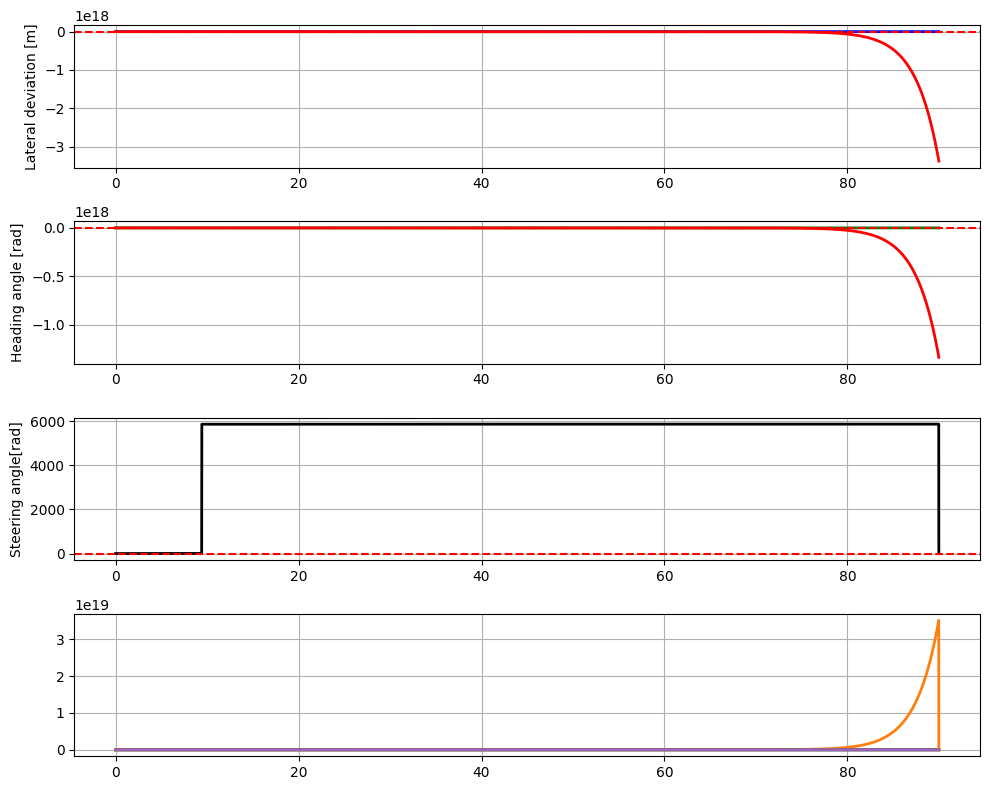

In [ ]:
#real_model = make_acados_model(KinematicBycicleActuator(), "car_model")

real_model = make_acados_model(KinematicBycicle(), "kinematic")

controller = PID_Controller(K_fb=np.array([0.2, 0.2]), wheelbase = 1.0*2.5)

c_max = 0.01
c_bias = 0.01*0
d_curv_max = 10
dt = 0.01
N_repeat = 2
T_max = 45
t_list = np.arange(0, T_max, dt)
curv_reference = c_max * (np.tanh(d_curv_max * (t_list - 10)) + 1) / 2 - c_max * (np.tanh(d_curv_max * (t_list - 20)) + 1) / 2 + \
            - (c_max * (np.tanh(d_curv_max * (t_list - 30)) + 1) / 2 - c_max * (np.tanh(d_curv_max * (t_list - 40)) + 1) / 2) + c_bias

t_list = np.arange(0, T_max * N_repeat, dt)
curv_reference = np.hstack(N_repeat*[curv_reference])

vel_reference = 17*np.ones_like(t_list)
f_vel = interpolate.interp1d(t_list, vel_reference, kind = 'linear')
f_curv = interpolate.interp1d(t_list, curv_reference, kind = 'linear')

trajectory = TrajectoryTimeProfile(f_vel, f_curv)


times, states, controls, controls_actual, debug = simulate_car_control(real_model, controller, trajectory, dt, t_list)

print("Simulation completed!")
print(f"Final lateral deviation: {states[-1, 0]:.4f} m")
print(f"Final heading angle: {states[-1, 1]:.4f} rad")

plot_results(times, states, controls, controls_actual, debug)

In [7]:
%matplotlib ipympl
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy import interpolate
from numpy.linalg import eig
from scipy import linalg
import math
import copy
import matplotlib.pyplot as plt
from numpy.linalg import eig
from scipy import linalg
from systems import *
N1 = 6
N2 = 10
TABLE_SIZE = int(N1*N2)
N_Features = 2
ADAPT_VECTOR_SIZE = int(N_Features*TABLE_SIZE)
ADAPT_VECTOR_SIZE = 5

plt.close() 
plt.ioff()

# k_p = 420.9, k_v = 49.61, a = 18.601, b = 2304.0, d = 164.8, tau = 0.0017, v_ch = 26.2628

### INITIAL CONDITION
STATE_LENGTH = 4
STATE_LENGTH_REF = 6
T_max = 100#14.5
dt = 0.02
N_repeat = 1
what0 = np.array([0.0]*ADAPT_VECTOR_SIZE)
what0[0] = 0.0
what0[1] = -0.0
what0[2] = 0.0
whatf0 = np.copy(what0)
d0 = 0.12
phi0 = 1*np.pi/180
w0 = 0.0
wdot0 = 0.0
velocity0 = 20.0

### INPUT SIGNALS

# curv_reference = c_max * (np.tanh(1 * (t_list - 10)) + 1) / 2 - c_max * (np.tanh(1 * (t_list - 30)) + 1) / 2
t_list = np.arange(0, T_max, dt)
c_max = 0.004 
c_bias = 0.004*0
d_curv_max = 5/5

curv_reference = c_max * (np.tanh(d_curv_max * (t_list - 10)) + 1) / 2 - c_max * (np.tanh(d_curv_max * (t_list - 30)) + 1) / 2 + \
              - (c_max * (np.tanh(d_curv_max * (t_list - 50)) + 1) / 2 - c_max * (np.tanh(d_curv_max * (t_list - 80)) + 1) / 2) + c_bias
# curv_reference = c_max* (tan(t_list - 10, d_curv_max) -  tan(t_list - 30, d_curv_max) + \
#                          tan(t_list - 50, d_curv_max) -  tan(t_list - 80, d_curv_max))

t_list = np.arange(0, T_max * N_repeat, dt)
curv_reference = np.hstack(N_repeat*[curv_reference])

f_curv = interpolate.interp1d(t_list, curv_reference, kind ='cubic')
f_d_curv = interpolate.interp1d(t_list[1:], np.diff(curv_reference)/dt, kind ='cubic')

### MODEL PARAMS
Noise_w = 0.0  ### INITIAL CONDITION
wheelbase = 2.5
Delay = 0.1
N_delay_curcle = int(Delay/dt)

### CONTROL PARAMS
LYAMBDA = 1.0 * 0.9 
control_bias = 0.0005
use_distortion = 1
def disturbance(u):
    return (u + control_bias)*LYAMBDA

theta_true = np.array([(1 - LYAMBDA)/LYAMBDA, -control_bias/0.01, 0, 0, 0])
gam = np.array([0.1, 0.1, 0.1, 0.1, 0.1])*0.5
sig = np.array([1.0] * ADAPT_VECTOR_SIZE) * 1.0*0

K_fb = np.array([0.1, 0.2, 0.3])
K_fb_ref = np.array([0.1, 0.2, 0.3])
alfa_sm = 0.5
k_p = 420.9
k_v = 49.61
a = 5.601
b = 304.0
d = 164.8
tau = 0.0017
v_ch = 26.2628

#car_lateral  = DynamicBicycleFriction(m = 1580, J = 3650, a = 1.44, wheelbase = wheelbase, Cf = np.rad2deg(50*1e3), Cr = np.rad2deg(65*1e3)) # a = 1.44
real_model = make_acados_model(KinematicBycicleActuator(), "car_model_kinematic")
reference_model = make_acados_model(KinematicBycicleActuator(), "car_model_kinematic")
integrator = Integrator(real_model)
controller = SimplePID(wheelbase = wheelbase, K_fb = K_fb)


reference_model = KinematicBicycleActuaror(wheelbase = wheelbase,  kp = 420.9, kv = 49.61, dim = STATE_LENGTH)
controller_reference = SimplePID(wheelbase = wheelbase, K_fb = K_fb)



what = np.zeros(ADAPT_VECTOR_SIZE)
whatf = np.zeros(ADAPT_VECTOR_SIZE)

state0 = np.zeros(STATE_LENGTH)
state0[0] = d0
state0[1] = phi0
# state0[2] = w0

state = np.copy(state0)

state_reference = np.copy(state[:STATE_LENGTH])
A, B = car_lateral.get_lin_system_dyn( 0.0, velocity0)
eigs_close_loop_real = np.real(eig(get_close_loop_matrix(A, B, K_fb))[0])
if(not np.all(eigs_close_loop_real < 0.0)):
    raise BaseException("positive eigenvals")
### MRAC PARAMS
use_adaptation = 1
use_adaptation_part = 1
table_mrac = False

R = -np.array([1, 1, 0.1, 0.001, 0.001, 0.001])

def adaptation(state, what,  c, v, un, table):
    d = state[0]
    psi = state[1]
    f1 = un
    f2 = 0.01
    f3 = 0
    f4 = 0
    f5 = 0

    theta = np.array([f1, f2, f3*0, f4*0, f5*0])
    ua = what@theta
    vec_size = len(theta)
    ids = np.arange(0, vec_size)
    ids_features = np.arange(0, vec_size)
    return ua, ids, ids_features,  theta


### DEBAG SIGNALS
err_rec = np.zeros_like(t_list)
Lyap_full_rec = np.zeros_like(t_list)
Lyap_state_rec = np.zeros_like(t_list)
Lyap_what_rec = np.zeros_like(t_list)
debag_rec =  np.zeros((len(t_list), 1))
u_rec = np.zeros((len(t_list), 11))
state_rec = np.zeros((len(t_list),  max(STATE_LENGTH, 6) + 2*ADAPT_VECTOR_SIZE))
state_reference_rec = np.zeros((len(t_list), max(STATE_LENGTH, 6)))
u_hist = [0]
if(N_delay_curcle > 1) :
    u_hist = u_hist * N_delay_curcle
c_curr_last = f_curv(t_list[0])

def measurements(state):
    return state
    # d = state[0]
    # psi = state[1]
    # w = state[2]
    # wdot = state[3]
    # delta = state[4]
    # deltadot = state[5]
    # #w += np.random.normal(0, Noise_w)
    # w = w #- 0.002
    # psi = psi #+ 0.002
    # state_fb = np.hstack((d, psi, w, wdot, delta, deltadot))
    # return state_fb

for i in range(0, int(len(t_list))):
    if(np.linalg.norm(state) > 100):
        raise BaseException("Solution Disconverge")
    
    t = t_list[i]
    print("t:", t)
    c_curr = f_curv(t)
    
    i_future = i + N_delay_curcle
    if(i + N_delay_curcle > len(t_list)-1):
        i_future = i 

    t_future = t_list[i_future]  #predictor
    sys_state_fb = measurements(state)
    
    d = state[0]
    psi = state[1]
    v = velocity0

    A, B = car_lateral.get_lin_system_dyn(c_curr, v)
    P = get_lapynov_matrix(A, B, R, K_fb)
    Ar = get_close_loop_matrix(A, B, K_fb)

    # assert np.linalg.norm(((Ar.T@P + P@Ar) - np.diag(R))) < 1e-5
    assert np.all(np.linalg.eigvals(P) > 0)
    
    BTP = -B@P
   
    err = state[:STATE_LENGTH] - state_reference[:STATE_LENGTH]


    err_mrac = BTP[:STATE_LENGTH]@(err[:])

    uff, ufb = controller.get_nominal_control(K_fb, sys_state_fb, v, c_curr)

    ua, ids, ids_f, thetas = 0, [], [], []
    if(use_adaptation_part):
        ua, ids, ids_f, thetas = adaptation(sys_state_fb, what, c_curr, v, uff + ufb, False)
        assert len(ids) == len(thetas)

    u = uff + ufb + ua

    uff_ref, ufb_ref = controller_reference.get_nominal_control(K_fb[:2], state_reference, v, c_curr)
    un_ref = uff_ref + ufb_ref


    u_hist.pop(0)
    u_hist.append(u)

    u_delayed = u# u_hist[0]
    if(use_distortion):
        u_delayed = disturbance(u_delayed)

    soln_ref = odeint(lambda state_ , time_: reference_model.sys_dyn(state_, time_, un_ref, v, c_curr), np.copy(state_reference), (t, t + dt), atol = 1e-6, rtol = 1e-6)
    soln    =  odeint(lambda state_ , time_:     car_lateral.sys_dyn(state_, time_, u_delayed, v, c_curr), state[:STATE_LENGTH], (t, t + dt), atol = 1e-6, rtol = 1e-6)
        

    if(use_adaptation):
        for j, id in enumerate(ids):   
            f_id = ids_f[j]
            what[id] += (gam[f_id] * (thetas[j] * err_mrac)- sig[id] * (what[id] - whatf[id])) * dt
            whatf[id] += (alfa_sm * (what[id] - whatf[id])) * dt
            assert len(what) == ADAPT_VECTOR_SIZE
    c_curr_last = c_curr
    state = soln[ -1]
    state_reference = np.copy(soln_ref[ -1])  
    err_rec[i] = -err_mrac
    state_rec[i][:STATE_LENGTH] = state[:STATE_LENGTH]
    state_rec[i][max(STATE_LENGTH, 6):max(STATE_LENGTH, 6) + ADAPT_VECTOR_SIZE] = what
    state_rec[i][2] = car_lateral.get_psi_dot() #state[2] #- v * c_curr*0
    state_reference_rec[i][:STATE_LENGTH] = state_reference[:STATE_LENGTH]
    state_reference_rec[i][2] = reference_model.get_psi_dot()
    u_rec[i] = np.array([uff, ufb, ua, 0, u, 0, 0, 0, 0, 0, 0])

    #CALC LYAPUNOV FUNCTION
    P = P[:STATE_LENGTH, :STATE_LENGTH]
    Lyap_state_rec[i] =  err[:STATE_LENGTH]@P@err[:STATE_LENGTH,np.newaxis]
    Lyap_what_rec[i] =  ((what - theta_true)/gam)@((what - theta_true))*LYAMBDA
    Lyap_full_rec[i] =  Lyap_state_rec[i] +  Lyap_what_rec[i] 

print("Done")

fig, (axes) = plt.subplots(4, 2, figsize = (15, 15)  )
fig.suptitle('Simulation')
for ax_raw in axes:
    for ax in ax_raw:
        ax.grid(True)

ax = axes[0][0]
ax.plot(t_list, 180*state_rec[:, 2]/np.pi, label = r'$\Delta w$')
ax.plot(t_list, 180*state_reference_rec[:, 2]/np.pi, label = r'$\Delta w_{ref}$')
#ax.plot(t_list, state_rec[:, 4], label = r'$v$')
#ax.plot(t_list, f_curv(t_list) , label = r'$c_{ref}$')

ax.set_ylabel('deg/s', fontsize=20)
ax.set_xlabel('time /s', fontsize=20)
ax.legend(fontsize=20, loc = 'upper right')
ax.tick_params(axis='both', which='major', labelsize=20)

ax = axes[1][0]
# ax.plot(t_list, state_rec[:, 0], label = r'$d[m]$')
ax.plot(t_list, 180*state_rec[:, 1]/np.pi, label = r'$psi[deg]$')
ax.plot(t_list, 180*state_reference_rec[:, 1]/np.pi, label = r'$psi_{ref}[deg]$')
ax.set_ylabel('deg',  fontsize=20)
ax.set_xlabel('time /s',  fontsize=20)
ax.legend( fontsize=20, loc = 'upper right')
ax.tick_params(axis='both', which='major', labelsize=20)

ax = axes[0][1]
ax.set_ylabel('m', fontsize=20)
ax.plot(t_list, state_rec[:, 0], label = r'$d[m]$')
ax.plot(t_list, state_reference_rec[:, 0], label = r'$d_{ref}[m]$')
ax.legend( fontsize=20, loc = 'upper right')
ax.tick_params(axis='both', which='major', labelsize=20)

ax = axes[1][1]
ax.plot(t_list, u_rec[:, 0], label = r'$u_{ff}$')
ax.plot(t_list, u_rec[:, 1], label = r'$u_{fb}$')
ax.plot(t_list, u_rec[:, 2], label = r'$u_{a}$')
ax.plot(t_list, u_rec[:, 4], label = r'$u$')
ax.plot(t_list, u_rec[:, 5], label = r'$u_{unlim}$')
ax.plot(t_list, state_rec[:, 4], label = r'$\delta$')

ax.set_ylabel("u", fontsize = 20)
ax.legend(fontsize = 20, loc = 'upper right')
ax.set_xlabel('time /s', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=20)

ax = axes[2][0]
for i in range(0, ADAPT_VECTOR_SIZE):
    w = state_rec[:, max(STATE_LENGTH, 6) + i]
    ax.plot(t_list, w, label = f'w{i}')
    ax.axhline(theta_true[i], linestyle='--')

ax.set_ylabel(r'$W$', fontsize = 20)
ax.set_xlabel('time /s', fontsize = 20)
ax.legend(fontsize = 15, loc = 'upper right')
ax.tick_params(axis='both', which='major', labelsize=20)



ax = axes[2][1]
ax.plot(t_list, Lyap_full_rec, label = r'$L$')
ax.plot(t_list, Lyap_state_rec, label = r'$L_{state}$')
ax.plot(t_list, Lyap_what_rec, label = r'$L_{w}$')
ax.legend( fontsize=20, loc = 'upper right')
ax.tick_params(axis='both', which='major', labelsize=20)

ax = axes[3][0]
ax.plot(t_list, err_rec, label = r'$e_{mrac}$')
ax.legend( fontsize=20, loc = 'upper right')
ax.tick_params(axis='both', which='major', labelsize=20)


# ax = axes[3][0]
# ax.plot(t_list, 180*state_reference_rec[:, 1]/np.pi, label = r'$psi_{ref}[deg]$')
# # ax.plot(t_list, 180*state_reference_rec[:, 2]/np.pi, label = r'$w_{ref}$')
# ax.legend( fontsize=20, loc = 'upper right')


# ax = axes[3][1]
# ax.plot(t_list, state_reference_rec[:, 0], label = r'$d_{ref}[m]$')
# ax.legend( fontsize=20, loc = 'upper right')
plt.show()


NameError: name 'SimplePID' is not defined